In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv \
    -O /tmp/training_cleaned.csv

--2020-08-07 14:37:22--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.214.128, 173.194.216.128, 108.177.13.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.214.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 238942690 (228M) [application/octet-stream]
Saving to: ‘/tmp/training_cleaned.csv’

/tmp/training_clean 100%[===================>] 227.87M   139MB/s    in 1.6s    

2020-08-07 14:37:24 (139 MB/s) - ‘/tmp/training_cleaned.csv’ saved [238942690/238942690]



In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Conv1D, Activation, MaxPooling1D, Dropout


In [4]:
# create corpus
corpus = []
with open("/tmp/training_cleaned.csv", 'r') as f:
  reader = csv.reader(f, delimiter=',')
  for row in reader:
    list_item = []
    list_item.append(row[5])
    if row[0] == '0':
      list_item.append(0)
    else:
      list_item.append(1)
    corpus.append(list_item)


In [8]:
# hyperparameters
vocab_size = 0  # getting all the words, not just choosing n words with highest probabilities 
embedding_dims = 100
max_length = 16
padding_type = 'post'
trunc_type = 'post'
train_portion = 0.9



In [25]:
random.shuffle(corpus)
sentences = []
labels = []
for x in range(len(corpus)):
  sentences.append(corpus[x][0])
  labels.append(corpus[x][1])

tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index
vocab_size = len(word_index) 

sequences = tokenizer.texts_to_sequences(sentences)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)



In [26]:
print("number of words in the vocabulary: {}".format(vocab_size))

number of words in the vocabulary: 690960


In [13]:
# split 
split = int(len(corpus) * train_portion)
train_seq = padded_sequences[:split]
train_labels = labels[:split]
test_seq = padded_sequences[split:]
test_labels = labels[split:]

train_seq = np.array(train_seq)
train_labels = np.array(train_labels)
test_seq = np.array(test_seq)
test_labels = np.array(test_labels)

In [14]:
print(len(train_seq))

1440000


In [27]:
# 100 dimension GloVe from Stanford
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt
embeddings_index = {};
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dims));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

--2020-08-07 15:48:42--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.170.128, 172.217.204.128, 172.217.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.170.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M   159MB/s    in 2.1s    

2020-08-07 15:48:45 (159 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]



In [30]:
# model
model = Sequential()
model.add(Embedding(vocab_size+1, embedding_dims, input_length=max_length, weights=[embeddings_matrix], trainable=False))
model.add(Dropout(0.2))
model.add(Conv1D(64, 5))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(64))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 16, 100)           69096100  
_________________________________________________________________
dropout (Dropout)            (None, 16, 100)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 12, 64)            32064     
_________________________________________________________________
activation (Activation)      (None, 12, 64)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 3, 64)             0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 1)                

In [31]:
history = model.fit(train_seq, train_labels, epochs=50, validation_data=(test_seq, test_labels), verbose=2)

Epoch 1/50
45000/45000 - 309s - loss: 0.5413 - accuracy: 0.7192 - val_loss: 0.5032 - val_accuracy: 0.7487
Epoch 2/50
45000/45000 - 301s - loss: 0.5167 - accuracy: 0.7385 - val_loss: 0.4940 - val_accuracy: 0.7541
Epoch 3/50
45000/45000 - 292s - loss: 0.5101 - accuracy: 0.7428 - val_loss: 0.4911 - val_accuracy: 0.7567
Epoch 4/50
45000/45000 - 287s - loss: 0.5061 - accuracy: 0.7458 - val_loss: 0.4894 - val_accuracy: 0.7585
Epoch 5/50
45000/45000 - 297s - loss: 0.5040 - accuracy: 0.7471 - val_loss: 0.4903 - val_accuracy: 0.7581
Epoch 6/50
45000/45000 - 295s - loss: 0.5027 - accuracy: 0.7482 - val_loss: 0.4859 - val_accuracy: 0.7608
Epoch 7/50
45000/45000 - 291s - loss: 0.5013 - accuracy: 0.7495 - val_loss: 0.4861 - val_accuracy: 0.7598
Epoch 8/50
45000/45000 - 277s - loss: 0.5002 - accuracy: 0.7504 - val_loss: 0.4875 - val_accuracy: 0.7585
Epoch 9/50
45000/45000 - 274s - loss: 0.4995 - accuracy: 0.7508 - val_loss: 0.4864 - val_accuracy: 0.7601
Epoch 10/50
45000/45000 - 295s - loss: 0.4991 

<Figure size 432x288 with 0 Axes>

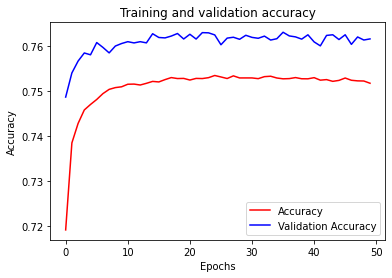

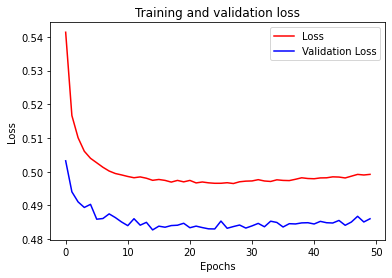

<Figure size 432x288 with 0 Axes>

In [32]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!